<a href="https://colab.research.google.com/github/JakobRobnik/MicroCanonicalHMC/blob/master/positive_constraints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Positive constrains

Suppose we want to sample from some target $p(\boldsymbol{x})$ which is not defined on $\mathbb{R}^d$. Instead, some of the parameters are constrained to be positive.

I think the cleanest way to do sampling is to extend the definition domain to $\mathbb{R}^d$ by reflection. So if the parameter $x_i$ must be positive, we simply define $p(-x_i) = p(x_i)$. After we are done with sampling we reflect the samples back by taking the absolute value of those parameters.

Bellow I define a MCHMC target class which takes in the target defined on the restricted domain and extends it to the unconstrained space. Its transform attribute reflects back to the original domain at the end of sampling.

In [12]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

In [13]:
class PositiveConstraint:

    def __init__(self, target, positive):
        """takes in a target and enforces some of the parameters to be positive
           positive is an array of lenght target.d
           positive[i] = 1 if the i-th parameter must be positive and 0 otherwise
        """
        self.positive = positive

        # get the attributes from the previous target
        self.d = target.d
        self.transform = self.reflection

        self.nlogp = lambda x: target.nlogp(self.reflection(x)) #we extend the domain by reflection p(-x_i) = p(x_i) for parameters which need to be positive
        self.grad_nlogp = jax.value_and_grad(self.nlogp)

        
        if hasattr(target, 'transform'):
            self.transform = lambda x: target.transform(self.reflection(x)) # at the end we reflect the samples back to the original domain
        else:
            self.transform = self.reflection

        self.prior_draw = target.prior_draw


    def reflection(self, x):
        return x * jnp.sign(jnp.sign(x) + 2 - 2 * self.positive)

Let's test this on an example. Suppose we want to sample from a standard Gaussian, but some of the parameters must be positve. We have defined a target class:

In [14]:
class StandardNormal():
    """Standard Normal distribution in d dimensions"""

    def __init__(self, d):
        self.d = d
        self.variance = jnp.ones(d)
        self.nlogp = lambda x: 0.5 * jnp.sum(jnp.square(x), axis= -1)
        self.grad_nlogp = jax.value_and_grad(self.nlogp)
        self.transform = lambda x: x
        self.prior_draw = lambda key: jnp.abs(jax.random.normal(key, shape = (self.d, ), dtype = 'float64'))

d = 100
target_original = StandardNormal(d = 100)

Now we impose the positivity constraint. This is achieved by passing the original target to `PositiveConstraint` and specifying which parameters must be positive. `positive` is an array with `positive[i] = 1` if the i-th parameter must be positive and 0 otherwise. 

In this example let the first 50 parameters be constrained:

In [ ]:
d = 100
num_positive = 50
positive = jnp.concatenate((jnp.ones(num_positive), jnp.zeros(d-num_positive)))
target= PositiveConstraint(target_original, positive)

We can now simply use `target` in MCHMC and we will get the desired results. Let's download the MCHMC:

In [ ]:
!git clone https://github.com/JakobRobnik/MicroCanonicalHMC.git
from MicroCanonicalHMC.sampling.sampler import Sampler

and do the sampling:

In [7]:
sampler = Sampler(target, 10.0, 5.0, integrator= 'LF')
x, burnin = sampler.sample(10000)
x= x[burnin:]

Let's visualize the results:

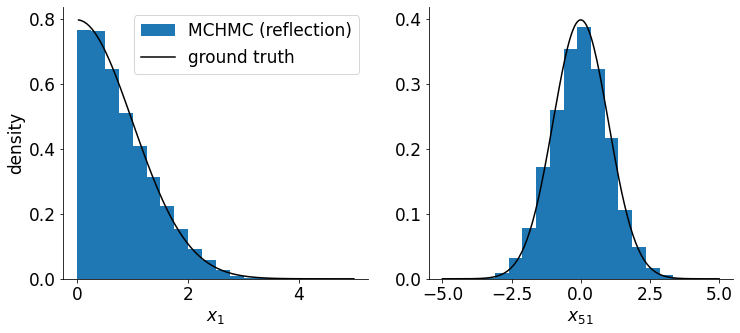

In [20]:
plt.rcParams.update({'font.size': 17, 'axes.spines.right': False, 'axes.spines.top': False})

plt.figure(figsize=(12, 5))

#ground truth
t = np.linspace(-5, 5, 200)
pdf = np.exp(-0.5*np.square(t))/np.sqrt(2 * np.pi)

bins = 15

plt.subplot(1, 2, 1)
plt.hist(x[:, 0], bins = bins, density= True, label = 'MCHMC (reflection)')
plt.plot(t[t>0], 2*pdf[t>0], color = 'black', label = 'ground truth')
plt.xlabel(r'$x_1$')
plt.ylabel('density')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(x[:, 50], bins = bins, density= True, label = 'MCHMC (reflection)')
plt.plot(t, pdf, color = 'black', label = 'ground truth')
plt.xlabel(r'$x_{51}$')

plt.show()